In [1]:
# import libraries
import os
from rdkit import Chem
from rdkit import Geometry
from rdkit.Chem import RDConfig
from rdkit.Chem import rdGeometry
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem.Pharm3D import Pharmacophore
from rdkit.Chem.Pharm3D.EmbedLib import EmbedPharmacophore
from rdkit.Chem.Pharm3D.EmbedLib import MatchPharmacophoreToMol
from rdkit.Chem.Pharm3D.EmbedLib import GetAllPharmacophoreMatches
from rdkit.Numerics import rdAlignment
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from py3Dmol import view
from IPython.display import display
import copy
from collections import defaultdict

In [2]:
#make featture factory
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

In [3]:
print(fdef.GetFeatureFamilies())

('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


In [4]:
# load example molecules
mols = [m for m in Chem.SDMolSupplier(os.path.join(RDConfig.RDDocsDir,'Book/data/cdk2.sdf'))]

In [5]:
# first molecule is defined as probe
probmol = mols[0]
prob_feats = fdef.GetFeaturesForMol(probmol)
prob_points= [list(x.GetPos()) for x in prob_feats]

0 Donor SingleAtomDonor 1 (10,)


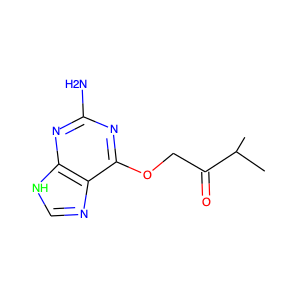

1 Donor SingleAtomDonor 2 (12,)


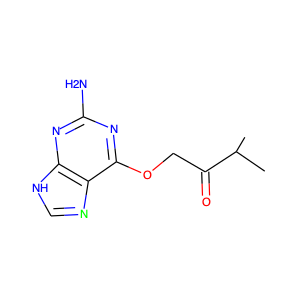

2 Donor SingleAtomDonor 3 (13,)


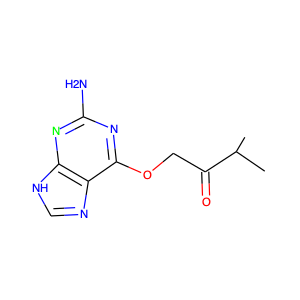

3 Donor SingleAtomDonor 4 (16,)


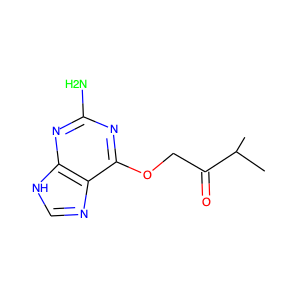

4 Acceptor SingleAtomAcceptor 5 (4,)


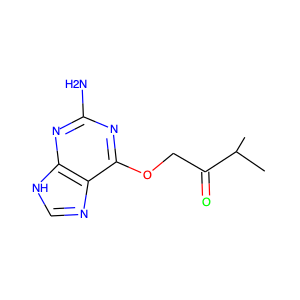

5 Acceptor SingleAtomAcceptor 6 (6,)


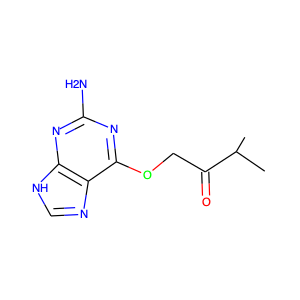

6 Acceptor SingleAtomAcceptor 7 (12,)


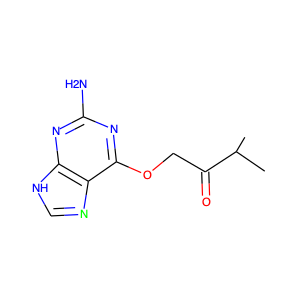

7 Acceptor SingleAtomAcceptor 8 (13,)


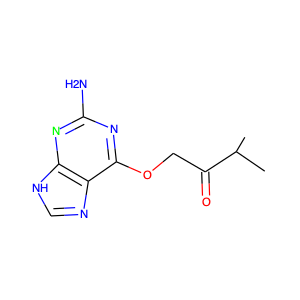

8 Acceptor SingleAtomAcceptor 9 (15,)


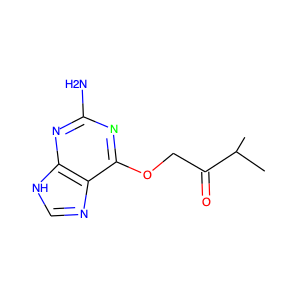

9 PosIonizable Imidazole 10 (8, 12, 11, 10, 9)


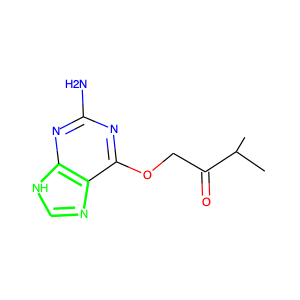

10 Aromatic Arom5 11 (8, 9, 10, 11, 12)


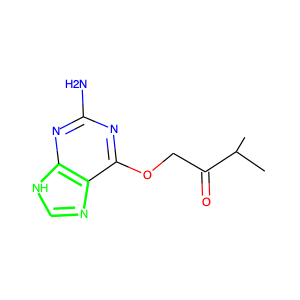

11 Aromatic Arom6 12 (7, 8, 9, 13, 14, 15)


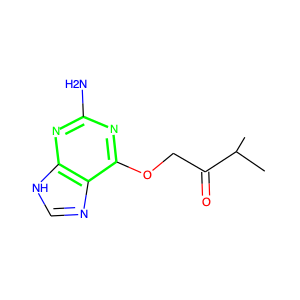

12 Hydrophobe ThreeWayAttach 13 (1,)


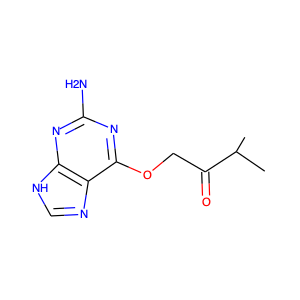

13 LumpedHydrophobe iPropyl 14 (1, 0, 2)


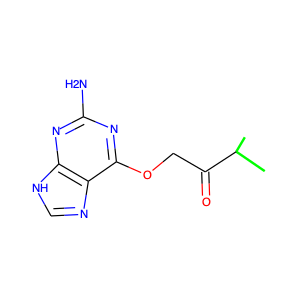

In [6]:
# check pharmacophore of prob molecule
for i, feat in enumerate(prob_feats):
    atomids = feat.GetAtomIds()
    print(i, feat.GetFamily(), feat.GetType(), feat.GetId(), atomids)
    display(Draw.MolToImage(probmol, highlightAtoms=list(atomids), highlightColor=[0,1,0], useSVG=True))
    
    

In [7]:
# define  three molecular features as pharmacophore 
feats = [prob_feats[6], prob_feats[9], prob_feats[11]]
feats_points = [(feat.GetPos().x, feat.GetPos().y, feat.GetPos().z) for feat in feats]

In [8]:
# define pharamcophore and upper and lowe bound. It used for p4core query
p4core = Pharmacophore.Pharmacophore(feats)
d01 = rdGeometry.Point3D.Distance(feats[0].GetPos(), feats[1].GetPos())
d02 = rdGeometry.Point3D.Distance(feats[0].GetPos(), feats[2].GetPos())
d03 = rdGeometry.Point3D.Distance(feats[1].GetPos(), feats[2].GetPos())
print(d01, d02, d03)
d_upper = 1.5
d_lower = 0.5
p4core.setLowerBound(0, 1, d01 - d_lower)
p4core.setUpperBound(0, 1, d01 + d_upper)
p4core.setLowerBound(0, 2, d02 - d_lower)
p4core.setUpperBound(0, 2, d02 + d_upper)
p4core.setLowerBound(1, 2, d03 - d_lower)
p4core.setUpperBound(1, 2, d03 + d_upper)

1.217954524109993 2.7768530212574567 2.09294922978716


In [9]:
# retreive molecules which has defined pharmacophore
match_mol = []
not_match_mol = []
for mol in mols[1:]:
    match, mList = MatchPharmacophoreToMol(mol, fdef, p4core)
    if match:
        match_mol.append((mol,mList))
    else:
        not_match_mol.append((mol,mList))

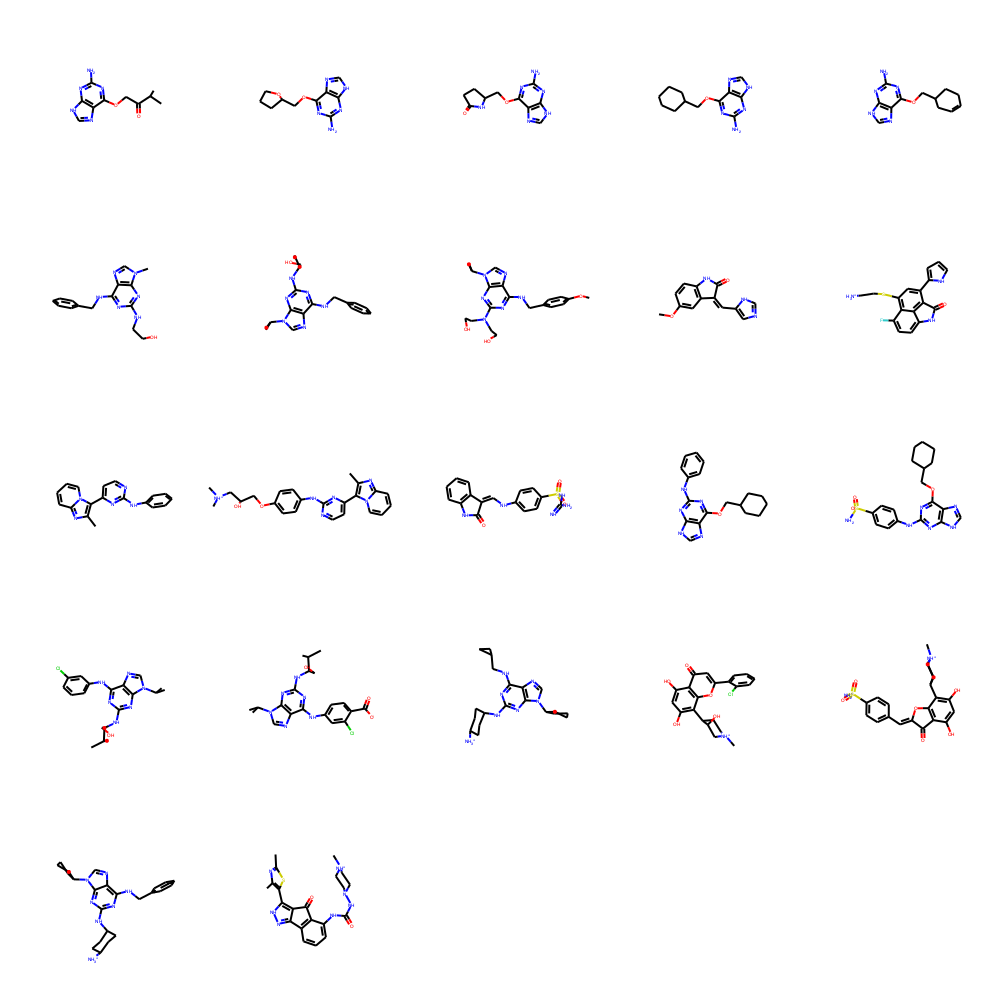

In [10]:
Draw.MolsToGridImage([probmol]+[x[0] for x in match_mol], molsPerRow=5)

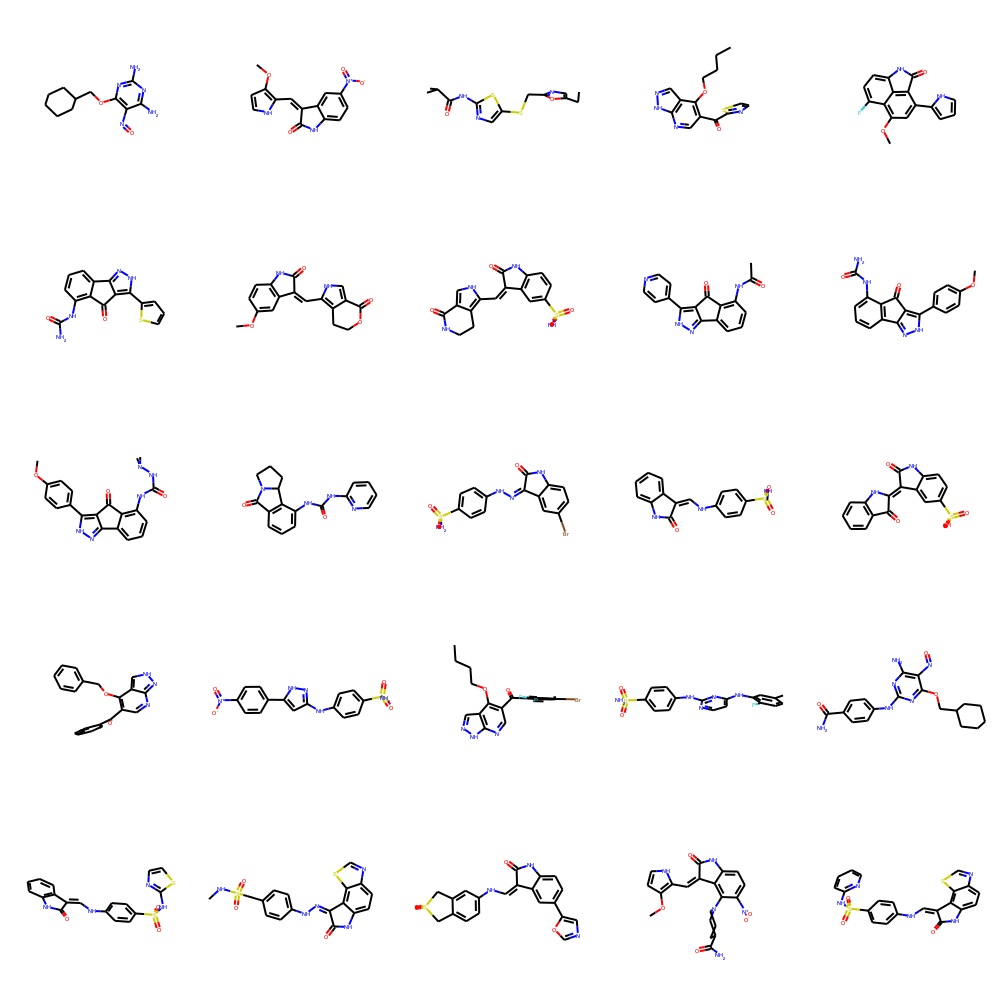

In [11]:
Draw.MolsToGridImage([x[0] for x in not_match_mol], molsPerRow=5)

In [12]:
phMatches_list = []
pLists = []
for mol, mList in match_mol:
    #Get distance matrix
    bounds = rdDistGeom.GetMoleculeBoundsMatrix(mol)
    pList =  GetAllPharmacophoreMatches(mList, bounds, p4core)
    pLists.append(pList)
    pMatches = []
    for i in range(len(pList)):
        pMatch = []
        for j in range(len(pList[i])):
            pMatch.append(pList[i][j].GetAtomIds())
        pMatches.append(pMatch)
    phMatches_list.append(pMatches)

In [13]:
print(len(phMatches_list), len(match_mol))

21 21


In [14]:
res = defaultdict(list)
for i, (mol, mList) in enumerate(match_mol):
    if phMatches_list[i] != []:
        for pMatch in phMatches_list[i]:
            Chem.FindMolChiralCenters(mol)
            bm, embeds, nFail = EmbedPharmacophore(mol, pMatch, p4core, count=20, silent=1)
            if nFail < 20:
                for embed in embeds:
                    AllChem.UFFOptimizeMolecule(embed)
                    m = copy.deepcopy(embed)
                    if m != None:
                        res[i].append(m)
            

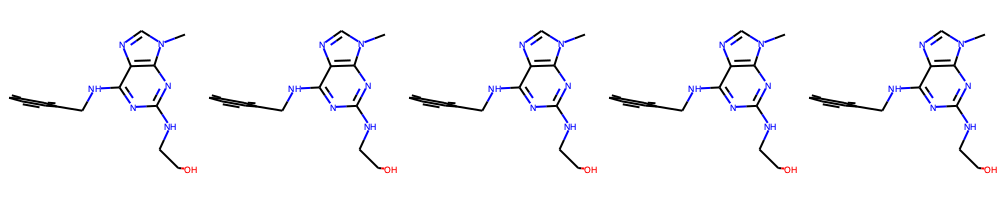

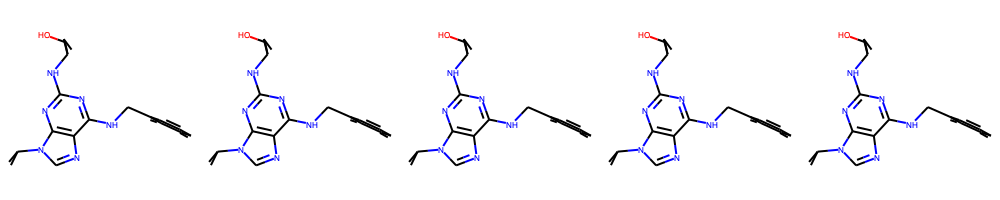

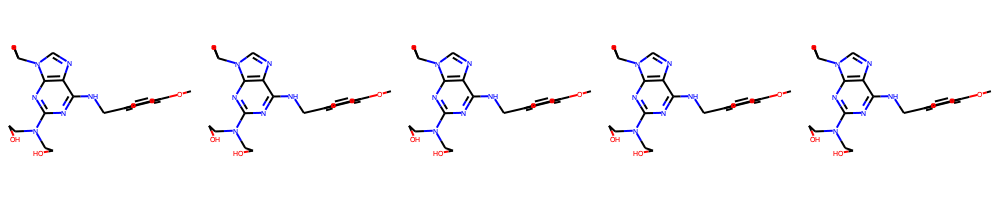

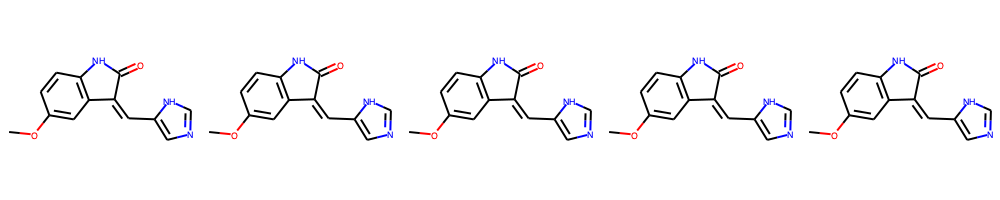

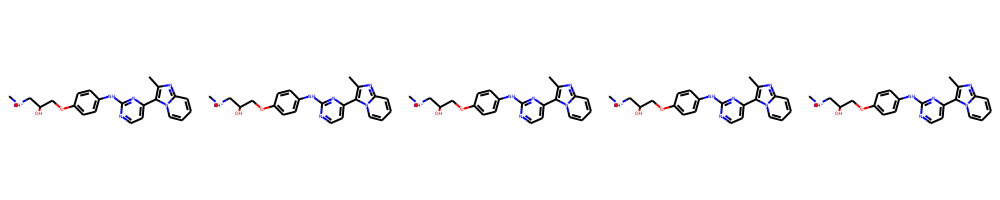

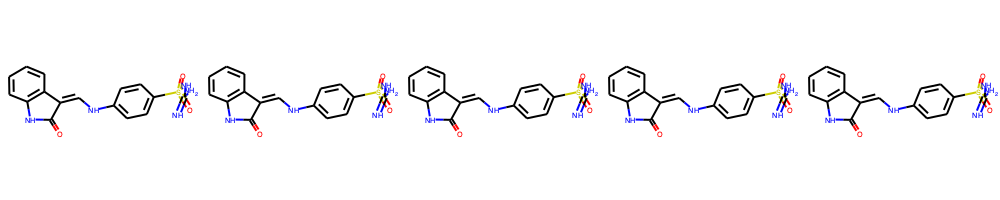

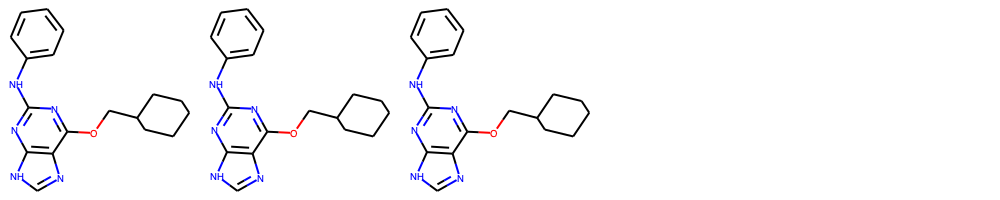

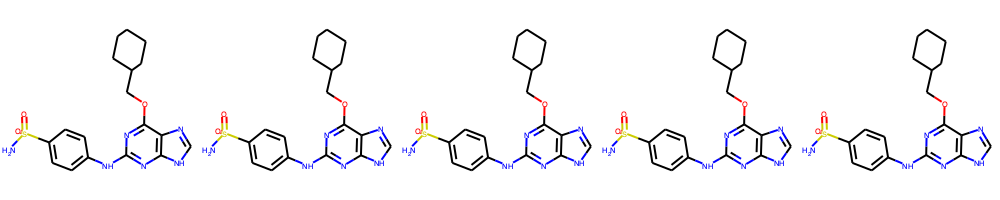

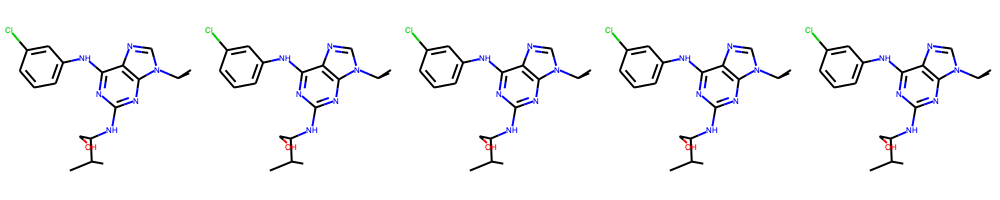

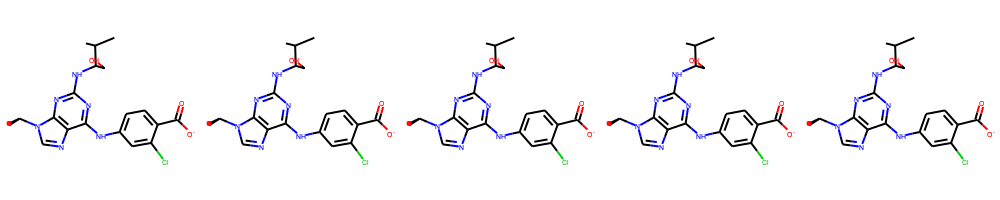

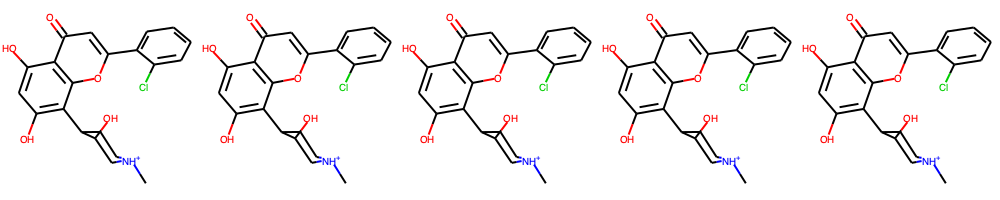

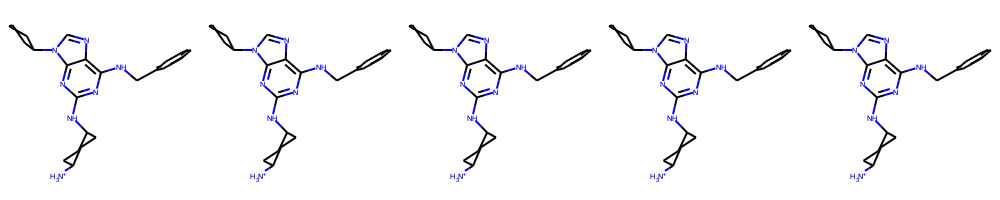

In [15]:
for i in range(len(match_mol)):
    if res[i] != []:
        display(Draw.MolsToGridImage(res[i][:5], molsPerRow=5))

In [16]:
ref = [list(p.GetPos()) for p in p4core.getFeatures()]
prob = [list(p.GetPos()) for p in pLists[4][1]]
aligndata = rdAlignment.GetAlignmentTransform(ref, prob)
aligndata

(38.58922032529166,
 array([[-0.29035723, -0.95436193,  0.06989988, -2.73473002],
        [-0.95690057,  0.28913118, -0.02728485, -0.5187307 ],
        [ 0.00582938, -0.07480959, -0.9971808 ,  0.0519065 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [17]:
AllChem.TransformMol(match_mol[4][0], aligndata[1])

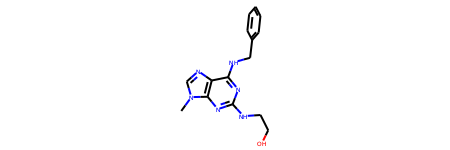

In [18]:
match_mol[4][0]

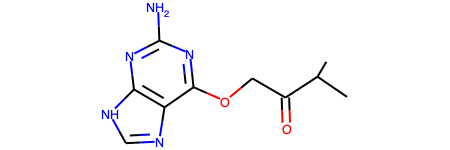

In [19]:
probmol